<i>Author: Linwood Creekmore<br>
Email: valinvescap@gmail.com</i>

# Getting Started 

Make sure you have installed all the libraries in the import section below.  If you get any errors, look up the documentation for each library for help.  

In [23]:
import geoplot as gplt
import gdelt
import re
import numpy as np
import pandas as pd
import datetime
from tzwhere import tzwhere 
import pytz

tz1 = tzwhere.tzwhere(forceTZ=True)

# Setting up `gdeltPyR`

It's easy to set up `gdeltPyR`.  This single line gets us ready to query.  See the [github project page](https://github.com/linwoodc3/gdeltPyR/blob/master/README.md) for details on accessing other tables and setting other parameters. Then, we just pass in a date to pull the data.  It's really that simple.  The only concern, is memory.  Pulling multiple days of GDELT can consume lots of memory.  Make a workflow to pull and write the disc if you have issues.  

In [25]:
gd = gdelt.gdelt()

%time marawi = gd.Search(['2017 May 23'],normcols=True)

# Time format transformations

These custom function handle time transformations.

In [26]:



def striptimen(x):
    """Strip time from numpy array or list of dates that are integers"""
    date = str(int(x))
    n = np.datetime64("{}-{}-{}T{}:{}:{}".format(date[:4],date[4:6],date[6:8],date[8:10],date[10:12],date[12:]))
    return n

def timeget(x):
    '''convert to datetime object with UTC time tag'''
    
    try:
        now_aware = pytz.utc.localize(x[2].to_pydatetime())
    except:
        pass
    
    # get the timezone string representation using lat/lon pair
    try:
        timezone_str=tz1.tzNameAt(x[0],x[1],forceTZ=True)
        
            # get the time offset
        timezone = pytz.timezone(timezone_str)

        # convert UTC to calculated local time
        aware = now_aware.astimezone(timezone)
        return aware
    
    except Exception as e:
        pass

# vectorize our two functions
vect = np.vectorize(striptimen)
vect2=np.vectorize(timeget)

Now we apply the functions to create a datetime object column (`dates`) and a timezone aware column (`datezone`).

In [27]:
dates = vect(marawi.dateadded.values)
marawi = marawi.assign(dates=dates)
marawi.set_index(dates,inplace=True)

In [28]:
datetz = [timeget(l) for l in marawi[['actiongeolat','actiongeolong','dates']][marawi[['actiongeolat','actiongeolong','dates']].notnull()==True].values.tolist()]
marawi=marawi.assign(datezone=datetz)

# Filtering to a city and specific CAMEO Code

I return data in `pandas dataframes` to leverage the power of pandas data manipulation.  Now we filter our data on the two target fields; actiongeofeatureid and eventrootcode.  To learn more about the columns, see [this page with descriptions for each header](https://github.com/linwoodc3/gdelt2HeaderRows/blob/master/schema_csvs/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv).

In [29]:
maute2= marawi[(marawi.actiongeofeatureid=='-2438515') \
               & (marawi.eventrootcode=='19')]

maute2.sort_values('datezone')[['datezone','sourceurl']].drop_duplicates('sourceurl').head()

In [30]:
# Alternative to strip all known website domains and add to regex

# endings = pd.read_html('https://iwantmyname.com/domains/domain-name-registration-list-of-extensions')[0]
# endings.columns = ['Domain extension','USD per year','Description']
# endings = endings.assign(doms=endings['Domain extension'].apply(lambda x: ("\\"+ x.split(' ')[0])))
# endingslist = endings['doms'].values.tolist()
# endingslist.append('\.IE')
# endingsString = "|".join(endingslist)

#  Stripping out unique news providers

This regex extracts baseurls from the `sourceurl` column.  These extractions allow us to analyze the contributions of unique providers in GDELT `events` data.  

In [32]:
# known domain regex
# r = re.compile('()({})'.format(endingsString),flags = re.IGNORECASE)

# lazy meta-character regex; more elegant
s = re.compile('(http://|https://)([A-Za-z0-9_\.-]+)')

##  Counting Who Produced the Most

We use pandas to find the provider with the most unique content.  One drawback of GDELT, is repeated URLs.  But, in the pandas ecosystem, removing duplicates is easy.  We extract provider baseurls, remove duplicates, and count the number of articles.  

In [54]:
frame = maute2

frame = frame.drop_duplicates(['sourceurl'])

frame=frame.assign(provider=frame.sourceurl.\
      apply(lambda x: s.search(x).group() if s.search(x) else np.nan))

groups = frame.groupby(['provider']).size().sort_values(ascending=False).reset_index()
groups.columns = ['provider','count']
groups

,provider,count
0,http://www.philstar.com,5
1,http://news.abs-cbn.com,5
2,http://cnnphilippines.com,3
3,http://www.interaksyon.com,3
4,http://www.gmanetwork.com,3
5,http://newsinfo.inquirer.net,2
6,http://www.dnaindia.com,2
7,http://www.dailymail.co.uk,2
8,http://www.channelnewsasia.com,2
9,http://www.rappler.com,2


# Finding Who Produced the "Fastest"

This block of code finds the news provider who produced reports faster "on average".  We convert the date of each article to epoch time, average across providers, and compare.  Again, `pandas` makes this easy.

In [35]:
frame2 = frame.copy()[frame.provider.notnull()==True].drop_duplicates('sourceurl')[['provider','sourceurl','dates']]

In [36]:
frame2 = frame2.assign(dates=frame2['dates'].apply(lambda x: (x.to_pydatetime().timestamp())))

In [37]:
grp = frame2.groupby('provider').filter(lambda x: len(x)>=3).groupby('provider')

In [38]:
final = grp.agg([np.mean,np.max,np.min]).sortlevel('mean',ascending=False)
newfinal = pd.DataFrame(final['dates']['mean'].apply(lambda x:datetime.datetime.fromtimestamp(int(x))).sort_values(ascending=True)).reset_index().set_index('mean',drop=False)
newfinal = newfinal.tz_localize('UTC')
newfinal = newfinal.tz_convert('Asia/Manila')
newfinal.columns = ['provider','UTC Time']
newfinal.index.name='Philippines Time'
# print(newfinal.to_html())

# A quick visual

I saw a video of the GDELT creator making a normalized time series with GDELT data.  This code below does the same.  First, we normalize the count of events for our target CAMEO Code against the total amount of events (per hour).  `pandas` resampling and time series functionality makes this easy.  Then, we use normal `matplotlib` syntax to create the plot.  The `economist` style is my custom style but I can share if requested.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


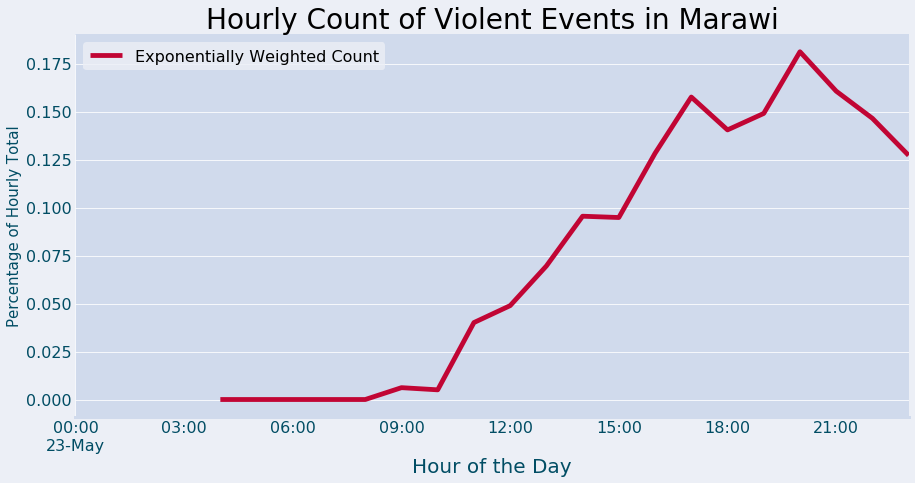

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('fivethirtyeight)
# mpl.style.use('economist')
timeseries= pd.concat([marawi.resample('H')['sourceurl'].count(),maute2.resample('H')['sourceurl'].count()]
         ,axis=1)
timeseries.fillna(0,inplace=True)
timeseries.columns = ['Total Events','Marawi Violent Events Only']
timeseries = timeseries\
.assign(Normalized=(timeseries['Marawi Violent Events Only']/timeseries['Total Events'])*100)
f,ax = plt.subplots(figsize=(13,7))
ax = timeseries.Normalized\
.ewm(adjust=True,ignore_na=True,min_periods=5,span=12).mean()\
.plot(color="#C10534",label='Exponentially Weighted Count', linewidth=4.8)
ax.set_title('Hourly Count of Violent Events in Marawi',fontsize=28)
for label in ax.get_xticklabels():
      label.set_fontsize(16)
ax.set_xlabel('Hour of the Day', fontsize=20)
ax.set_ylabel('Percentage of Hourly Total',fontsize='15')
ax.legend()
plt.tight_layout()
plt.savefig('../assets/img/countGraphic.png')
# pd.date_range(start='2017 23 May 00:00:00', end='2017 23 May 23:59:59',freq='1H')

# Getting the Content

This code gets the content (or tries to) at the end of each GDELT sourceurl.

In [1]:
# Author: Linwood Creekmore
# Email: valinvescap@gmail.com
# Description:  Python script to pull content from a website (works on news stories).

###################################
# Standard Library imports
###################################

import re
from io import BytesIO

###################################
# Third party imports
###################################

import requests
import numpy as np
from bs4 import BeautifulSoup


# placehoder to store completed urls; like caching
done ={}
def textgetter(url):
    """Scrapes web news and returns the content
    
    Parameters
    ----------
    
    url : str
        Address to news report
        
    newstext: str
        Returns all text in the "p" tag.  This usually is the content of the news story.
        
    Returns
    ----------
    
    dict: key/value
        Returns dictionary with key = url and value = content/message
    """
    global done
    
    # regex for url check
    s = re.compile('(http://|https://)([A-Za-z0-9_\.-]+)')
    
    # check that its an url
    if s.search(url):
        if url in done.keys():
            return done[url]
            pass
        else:
            
            # Make the call to the new story
            r  = requests.get(url)
            # check for a good response; return message otherwise
            if r.status_code != 200:
                done[url]="Unable to reach website."
                return {url:"Unable to reach website."}
            # store bytes of message in variable
            data = r.content
            # parse HTML 
            soup = BeautifulSoup(data,'html.parser')
            # strip paragraphs from HTML and join into a string
            newstext = " ".join([l.text for l in soup.find_all('p')])
            # add to done dictionary to prevent duplication
            done[url]=newstext
            # delete the response; save memory
            del r
            # check if return is longer than average sentence
            if len(newstext)>200:
                return {url:newstext}
            else:
                # check for another place where text is stored
                newstext = " ".join([l.text for l in soup.find_all('div',class_='field-item even')])
                done[url]=newstext
                # check for length; must be longer than a sentence
                if len(newstext)>200:
                    return {url:newstext}
                else:
                    # if all fails, return message
                    return {url: "No text returned"}
    else:
        # if we don't pass very first test; not a url
        return {url:"This is not a proper url."}

# Testing the Function

Here is a test.  The `done` dictionary is important; it keeps you from repeating calls to urls you've already processed.  It's like "caching".  

In [52]:
# A test

urls = frame2['sourceurl'].unique()
textgetter(urls[0])

{'http://www.philstar.com:8080/nation/2017/05/23/1702840/troops-maute-group-clash-marawi-city': 'LANAO DEL SUR, Philippines - Gunshots reverberated through villages in Barangay Basak Malulut in Marawi City as Maute gunmen and soldiers clashed there\xa0Tuesday, sending Maranaws running for their lives. Senior Superintendent Oscar Nantes, director of the Lanao del Sur provincial police, said the scene of the encounter is not too distant from their headquarters and the campus of the Mindanao State University. “We can hear automatic gunshots from where we are,”\xa0Nantes told The STAR at exactly\xa03:20 p.m.\xa0Tuesday. Local officials told The STAR loud explosions rocked the barangay as members of the Maute terror group and soldiers traded shots. The Maute group is also known as the Dawlah Islamiya Philippines, which espouses hatred to non-Muslims. It also boasts of loyalty to the Islamic State of Iraq and Syria and uses the black ISIS flag as its revolutionary banner. Nantes said personn

# Multiprocessing

This code implements a multiprocessed workflow over the data.  It's easy to do and works faster than an apply method over the dataframe.  

In [191]:
from concurrent.futures import ProcessPoolExecutor

e = ProcessPoolExecutor()
%time results = list(e.map(textgetter,urls))
# %time results2 = np.array(list(e.map(textgetter,d)))
# done = {}
# %time results3 = marawi.sourceurl.drop_duplicates()[1240:1245].apply(textgetter).values
# %time results3 = marawi.sourceurl.drop_duplicates()[1240:1245].apply(textgetter).values

CPU times: user 52.8 ms, sys: 42.1 ms, total: 94.9 ms
Wall time: 40.4 s


This joins the multiprocessed data:

In [187]:
sers = []

for l in results:
    ul = list(l.keys())[0]
    content = l[ul]
    sers.append(pd.Series({'url':ul,'content':content}))
connie = pd.concat(sers,axis=1).T

This merges the data back into the dataframe.  All of this data processing is enabled by `pandas`.

In [220]:
maute2 = maute2.merge(connie,left_on='sourceurl',right_on='url')

# Look at all the content

To build the narrative, now all you need to do is read.  This code extracts unique urls, orders chronologically based on time, and then prints the content for each url.  You can "Control F" or read through to build your timeline. 

In [ ]:
for l in maute2.drop_duplicates('sourceurl').sort_values('dates',ascending=True).content.values:
    print (l)

# Textgetter exceptions

If you find websites that don't return content, this section below can help you add to the textgetter Gist.  Just place the url in the `url` variable below, and print out the contents of `soup`.  Look for the tag with the content, and then add it to the `join` statement below.  Then, [drop a note on the Github gist](https://gist.github.com/linwoodc3/e12a7fbebfa755e897697165875f8fdb).

In [166]:
ur = 'http://www.philstar.com/nation/2017/05/23/1702882/marawi-residents-told-stay-home-firefights-continue'
page = requests.get(ur)
soup = BeautifulSoup(page.content,'html.parser')

In [ ]:
# prints content

soup

In [168]:
# How to merge content into a single string
" ".join([l.text for l in soup.find_all('div',class_='field-item even')])                

' Marawi is the gateway to Lanao del Sur, a component province of the Autonomous Region in Muslim Mindanao. Philstar.com/John Unson, file \n\tLANAO DEL SUR, Philippines \xa0— \xa0Officials on Tuesday urged Marawi City residents to stay home as firefights continued on city streets between Maute terrorists and soldiers.\n\n\t\xa0\n\n\tLanao del Sur Vice Gov. Mamintal Adiong, Jr., a senior member of the provincial peace and order council, also called on Marawi City residents to be extra vigilant and prevent strangers from intruding into their property.\n\n\t\xa0\n\n\t“I’m appealing to residents of Marawi City to stay home, drop on the ground if they hear gunshots. They have to lock their doors and gates too,” Adiong told The STAR via mobile phone on Tuesday afternoon.\n\n\t\xa0\n\n\tShooting between Islamic militants and personnel of the Army’s 103rd Infantry Brigade in Marawi City started at about 3:00 p.m. Tuesday, sending residents running for safety.\n\n\t\xa0\n\n\tSenior officials of